In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../..")
from pathlib import Path

from tqdm import tqdm_notebook
import pandas as pd
import numpy as np
import seaborn as sns
import torch.nn.functional as F
import matplotlib.pyplot as plt
import warnings
from sklearn.metrics import f1_score, precision_recall_fscore_support, precision_score
warnings.filterwarnings('ignore')

from src.data import label_to_string, string_to_label, DataPaths
from src.image import get_image_with_id, get_image_from_class, plot_rgby

#### Load in the results file and combine the training logs

In [37]:
# ROOT_PATH = Path("results/iafoss_resnet34_20181214-195627/training_logs")
ROOT_PATH = Path("results/gapnet_resnet34_20181214-195428/training_logs")

In [38]:
csv_paths = sorted(ROOT_PATH.glob("*.csv"), key=lambda x: int(x.stem.split("_")[1]))

In [39]:
string_to_num = lambda x: np.fromstring(x.strip("[]").replace("\n", ""), sep=" ")
def load_combined_df(paths):
    dfs = []
    for path in tqdm_notebook(paths):
        df = pd.read_csv(path)
        df['session'] = path.stem
        df['label'] = df['label'].map(string_to_num)
        df['label_class'] = df["label"].map(lambda x: np.where(x == 1)[0])
        df['label_names'] = df["label_class"].map(lambda x: [label_to_string[l] for l in x])
        df['prediction'] = df['prediction'].map(string_to_num)
        df['prediction_probs'] = df['prediction_probs'].map(string_to_num)
        df['prediction_class'] = df['prediction'].map(lambda x: np.where(x == 1)[0])
        df['prediction_names'] = df['prediction_class'].map(lambda x: [label_to_string[l] for l in x])
        
        dfs.append(df)
    return pd.concat(dfs)

In [40]:
csv_paths

[PosixPath('results/gapnet_resnet34_20181214-195428/training_logs/epoch_0_train.csv'),
 PosixPath('results/gapnet_resnet34_20181214-195428/training_logs/epoch_0_val.csv'),
 PosixPath('results/gapnet_resnet34_20181214-195428/training_logs/epoch_1_val.csv'),
 PosixPath('results/gapnet_resnet34_20181214-195428/training_logs/epoch_1_train.csv'),
 PosixPath('results/gapnet_resnet34_20181214-195428/training_logs/epoch_2_val.csv'),
 PosixPath('results/gapnet_resnet34_20181214-195428/training_logs/epoch_2_train.csv'),
 PosixPath('results/gapnet_resnet34_20181214-195428/training_logs/epoch_3_val.csv'),
 PosixPath('results/gapnet_resnet34_20181214-195428/training_logs/epoch_3_train.csv'),
 PosixPath('results/gapnet_resnet34_20181214-195428/training_logs/epoch_4_val.csv'),
 PosixPath('results/gapnet_resnet34_20181214-195428/training_logs/epoch_4_train.csv'),
 PosixPath('results/gapnet_resnet34_20181214-195428/training_logs/epoch_5_train.csv'),
 PosixPath('results/gapnet_resnet34_20181214-195428/t

In [41]:
combined_df = load_combined_df(csv_paths)

#### Calculate the f1 score for each class, and the f1 micro/macro for each epoch

In [42]:
def get_session_df(df, session):
    return df[df['session'] == session]

def get_metric_df(df):
    metric_data = []
    all_labels = np.stack(df.label.values)
    all_predictions = np.stack(df.prediction.values)
    for i in range(28):
        (_, precision), (_, recall), (_, f1_score), (_, n_labels)  = precision_recall_fscore_support(all_labels[:,i], all_predictions[:,i])
        data = {
            "precision": precision,
            "recall": recall,
            "f1_score": f1_score,
            "n_labels": n_labels,
            "class_name": label_to_string[i]
        }
        metric_data.append(data)
    metric_df = pd.DataFrame(metric_data)
    metric_df = metric_df.reindex_axis(['class_name', 'n_labels', 'precision', 'recall', 'f1_score'], axis=1)
    return metric_df

In [43]:
def create_combined_sessions_metrics_df(combined_df, sessions):
    metrics_df = []
    for i, s in enumerate(tqdm_notebook(sessions)):
        df = get_session_df(combined_df, s)
        metric_df = get_metric_df(df)
        metric_df['session'] = s
        metric_df['epoch'] = i
        metrics_df.append(metric_df)
    return pd.concat(metrics_df)

In [44]:
def create_combined_sessions_f1_score_df(comibined_df, sessions):
    f1_score_data = []
    for s in tqdm_notebook(sessions):
        df = get_session_df(combined_df, s)
        all_labels = np.stack(df.label.values)
        all_predictions = np.stack(df.prediction.values)
        micro_f1 = f1_score(all_labels, all_predictions, average='micro')
        macro_f1 = f1_score(all_labels, all_predictions, average='macro')
        f1_score_data.append(dict(micro_f1=micro_f1, macro_f1=macro_f1))
    return pd.DataFrame(f1_score_data).reindex_axis(['micro_f1', 'macro_f1'], axis=1)

In [45]:
train_sessions = [s for s in combined_df['session'].unique() if 'train' in s]
val_sessions = [s for s in combined_df['session'].unique() if 'val' in s]

In [46]:
train_metrics_df = create_combined_sessions_metrics_df(combined_df, train_sessions)
val_metrics_df = create_combined_sessions_metrics_df(combined_df, val_sessions)

In [47]:
train_f1_score_df = create_combined_sessions_f1_score_df(combined_df, train_sessions)
val_f1_score_df = create_combined_sessions_f1_score_df(combined_df, val_sessions)

In [48]:
train_f1_score_df

,micro_f1,macro_f1
0,0.475417,0.136260
1,0.562308,0.229520
2,0.593706,0.270389
3,0.611548,0.294907
4,0.624353,0.311810
5,0.632958,0.325042
6,0.639258,0.334195


In [49]:
val_f1_score_df

,micro_f1,macro_f1
0,0.595061,0.294929
1,0.618429,0.341598
2,0.607906,0.353249
3,0.586770,0.365805
4,0.635741,0.376592
5,0.639654,0.398468
6,0.660258,0.424746


In [50]:
train_metrics_df

,class_name,n_labels,precision,recall,f1_score,session,epoch
0,Nucleoplasm,36854,0.703014,0.681039,0.691852,epoch_0_train,0
1,Nuclear membrane,2765,0.637450,0.115732,0.195898,epoch_0_train,0
2,Nucleoli,9782,0.650307,0.270906,0.382478,epoch_0_train,0
3,Nucleoli fibrillar center,2995,0.508333,0.020367,0.039165,epoch_0_train,0
4,Nuclear speckles,4616,0.609110,0.124567,0.206835,epoch_0_train,0
5,Nuclear bodies,5342,0.547664,0.054848,0.099711,epoch_0_train,0
6,Endoplasmic reticulum,3352,0.482993,0.042363,0.077894,epoch_0_train,0
7,Golgi apparatus,8462,0.630063,0.152564,0.245647,epoch_0_train,0
8,Peroxisomes,195,0.000000,0.000000,0.000000,epoch_0_train,0
9,Endosomes,177,0.000000,0.000000,0.000000,epoch_0_train,0


In [53]:
val_metrics_df

,class_name,n_labels,precision,recall,f1_score,session,epoch
0,Nucleoplasm,4096,0.749939,0.751953,0.750945,epoch_0_val,0
1,Nuclear membrane,307,0.878788,0.377850,0.528474,epoch_0_val,0
2,Nucleoli,1087,0.861702,0.372585,0.520231,epoch_0_val,0
3,Nucleoli fibrillar center,333,0.485437,0.150150,0.229358,epoch_0_val,0
4,Nuclear speckles,513,0.788991,0.335283,0.470588,epoch_0_val,0
5,Nuclear bodies,594,0.574534,0.311448,0.403930,epoch_0_val,0
6,Endoplasmic reticulum,373,0.663043,0.163539,0.262366,epoch_0_val,0
7,Golgi apparatus,941,0.825651,0.437832,0.572222,epoch_0_val,0
8,Peroxisomes,22,0.000000,0.000000,0.000000,epoch_0_val,0
9,Endosomes,20,0.000000,0.000000,0.000000,epoch_0_val,0


In [51]:
import seaborn as sns

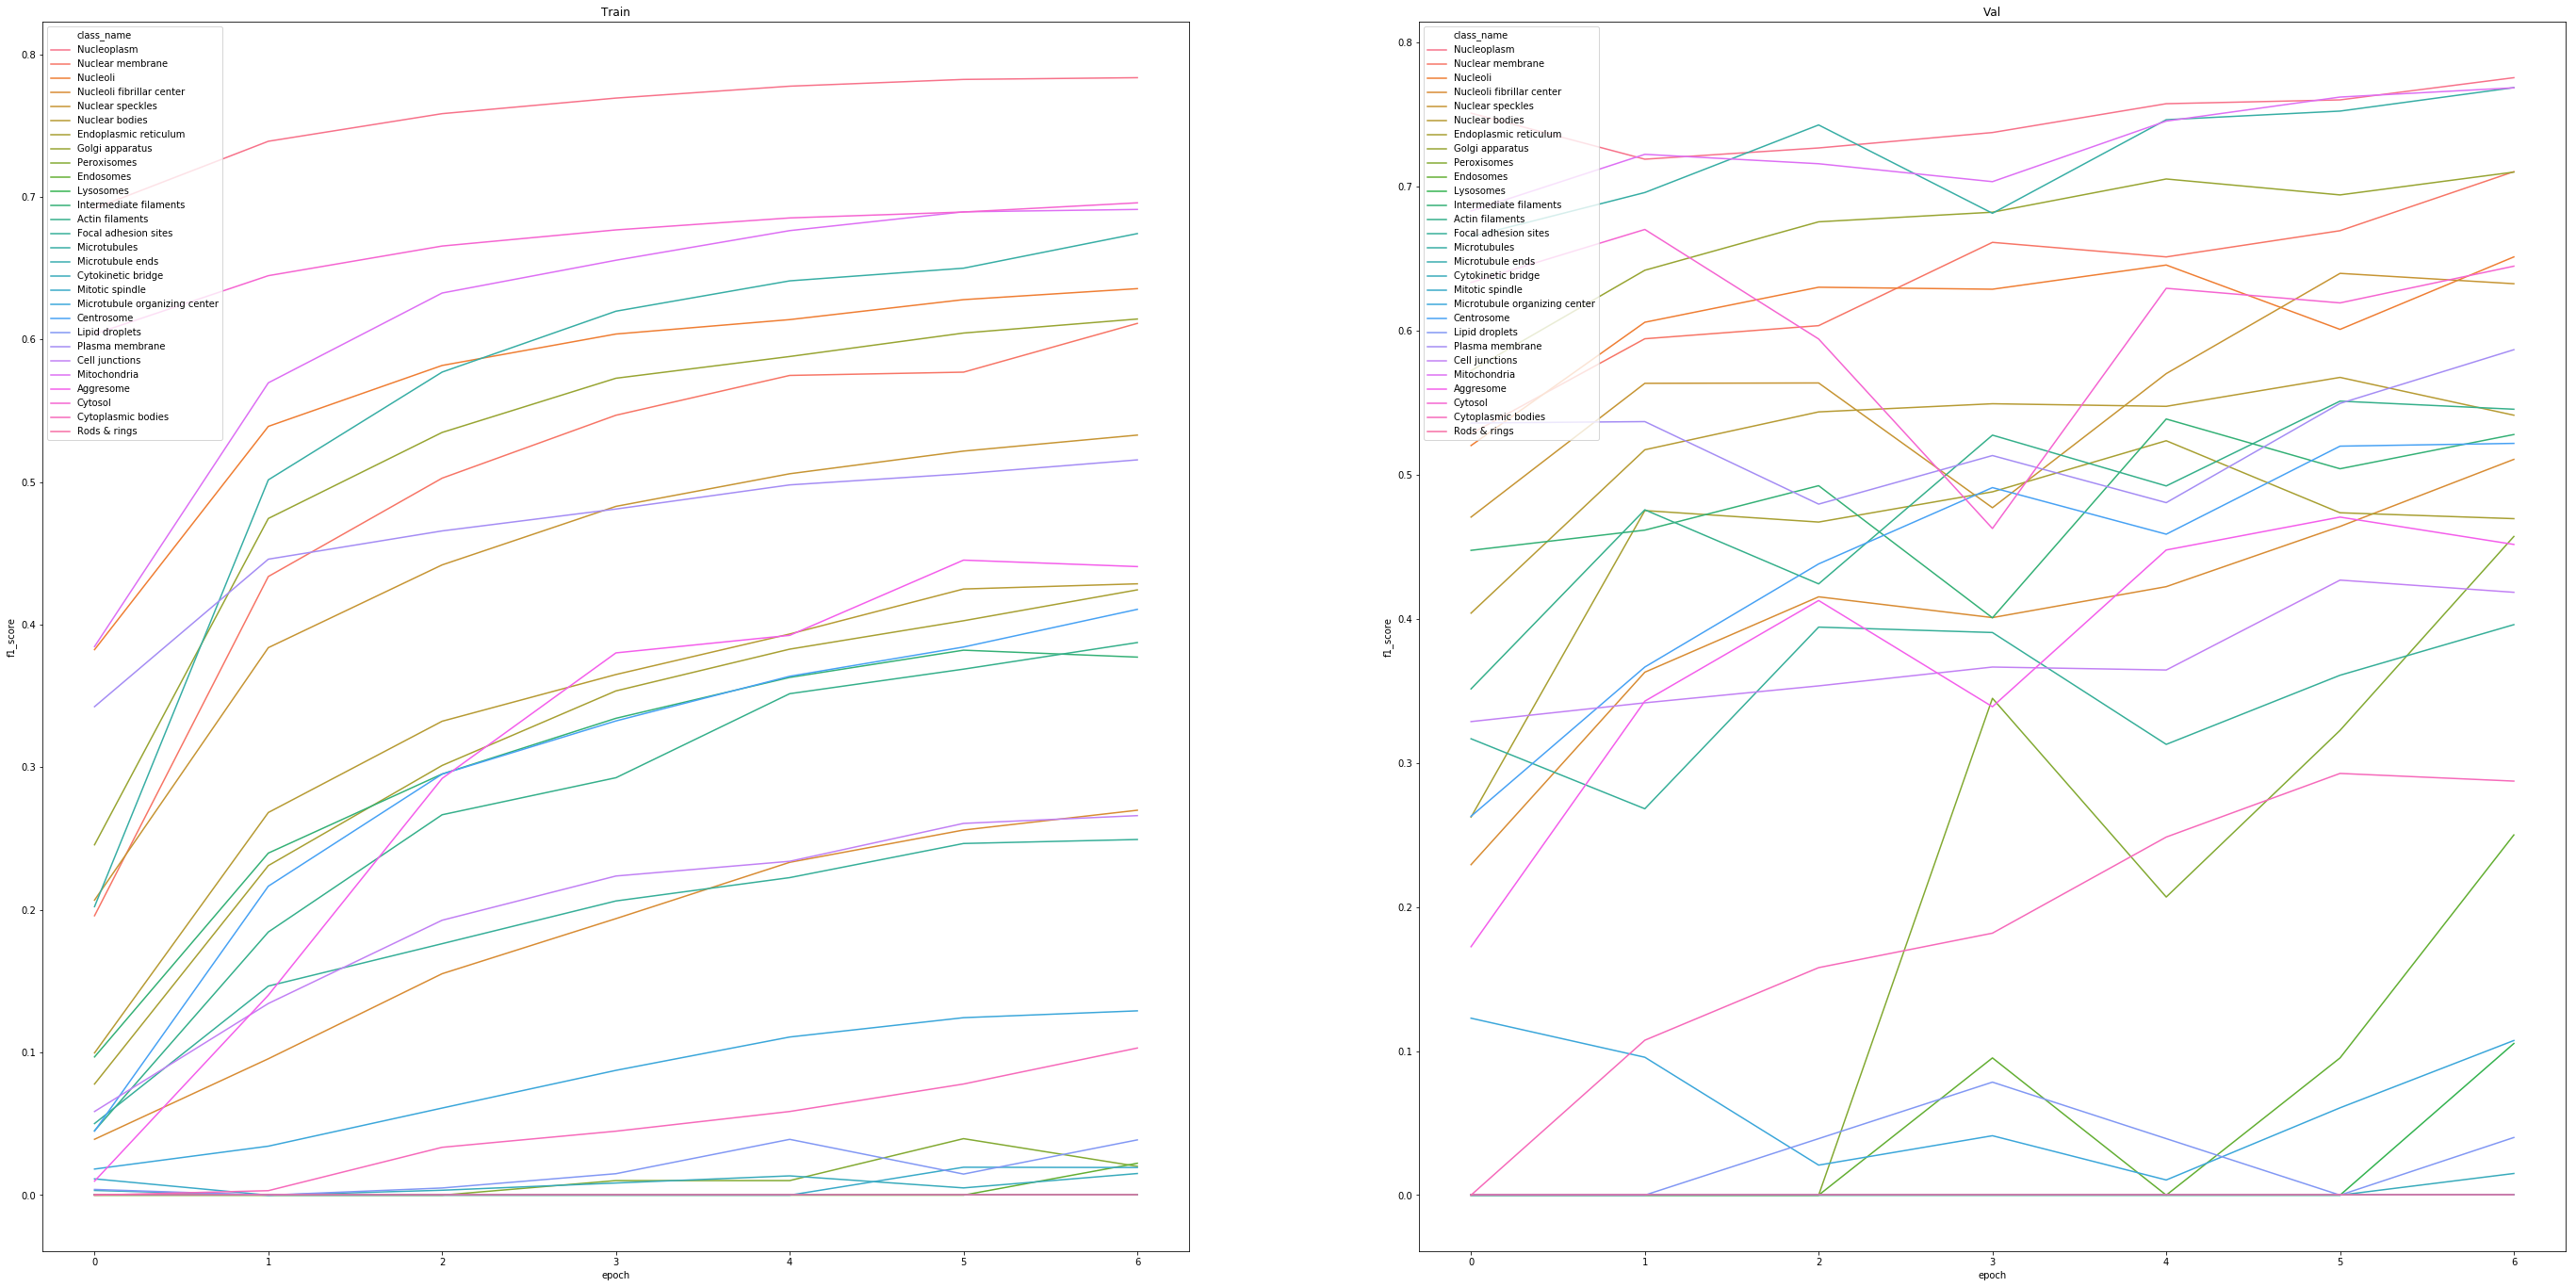

In [52]:
_, axs = plt.subplots(1, 2, figsize=(48, 24))
axs[0].set_title("Train")
sns.lineplot(x="epoch", y="f1_score", hue="class_name", data=train_metrics_df, legend="full", ax=axs[0])
axs[1].set_title("Val")
sns.lineplot(x="epoch", y="f1_score", hue="class_name", data=val_metrics_df, legend="full", ax=axs[1])